# _Notebook Jupyter_ 8_prediçãoRisco

# Predição do Risco dada uma Importação

O objetivo agora é dada uma importação contendo **kit de transmissão de motocicletas** fazer a sua classificação e em seguida apresentar uma análise de risco visual baseada na estatística existente de outras importações.<br>
É importante salientar que esta análise não substitui a acurada análise a ser realizada por um Auditor Fiscal, tendo em vista que o resultado será uma lista de parâmetros objetivos que indicarão graus de observação para o gerenciamento de risco.
Desse modo, a entrada será o registro de importação contendo todos os campos. A função determinará a classificação e com base nos valores declarados de outras importações da mesma classificação, fará a comparação analítica com o valor da importação em análise.

## Importando bibliotecas

In [1]:
import pandas as pd, time
import pickle
# Vetorização
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Modelos
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn import metrics
# Divisor de Treino/Treste
from sklearn.model_selection import train_test_split
# Matplot
import matplotlib.pyplot as plt

In [2]:
# importa funções criadas no módulo 3_classificarAplicação.ipynb (criarModelo.py)
from funcoesTCC import *
# Funções: criaModelo, limpaDescricao, achaPalavraChave, pegaChave, acrescentaMarca, retentorAux
# Variávis: stopwords, palavrasChave, Marcas
# Datasets: dftemp (Aplicações)

In [3]:
# Data e hora da execução do script
print(f'Código executado em {time.strftime("%d/%m/%Y às %H:%M", time.localtime(time.time()))}')

Código executado em 11/01/2022 às 13:00


## Treinamento do Classificador Linear SVC

Pela velocidade, versatilidade, facilidade de uso e, obviamente, a acurácia, optou-se pelo modelo do classificador Linear SVC.

In [4]:
# Importa base de dados com os modelos já determinados para um dataframe
df = pd.read_excel('dataframe_modelos_classificado.xlsx')
# Criação da função CountVectorizer
cvt = CountVectorizer(strip_accents='ascii', lowercase=True)
X_cvt = cvt.fit_transform(df['Modelo'])
# Criação da função TfidfTransformer
tfi = TfidfTransformer(use_idf=True)
X_tfi = tfi.fit_transform(X_cvt)


# A entrada será a transformação de vetores com a normalização tf-idf
#entrada = X_tfi
# A saida será as aplicações
#saida = df['APLICACAO']
# Separando 1% dos dados para teste
#X_train, X_test, y_train, y_test = train_test_split(entrada, saida, test_size=0.01)


# Como o modelo já foi testado, utilizaremos todo a base como treinamento
X_train=X_tfi.toarray()
y_train=np.array(df['APLICACAO'])

# Criando modelo
clfsvc = LinearSVC()
# Treinamento do modelo
clfsvc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Importando a Tabela ABIMOTO

In [5]:
dfABIMOTO = pd.read_excel('dfABIMOTOv13.xlsx')

In [6]:
dfABIMOTO.sample()

,ITEM,PARTES E PEÇAS,MOTO PARTS,NCM,UNI,VMLE,RETENTOR
3,81,KIT TRANSMISSÃO 1045 (CORRENTE.COROA. PINHAO) ...,TRANS.SET 1045 (CHAIN + SPROCKET) CBX 250 TWISTER,87141000,KIT,6.25,False


##### Função de classificação LinearSVC

In [7]:
def classificaAplicacaoSVC(modelo):
    novo_cvt = cvt.transform(pd.Series(modelo))
    novo_tfi = tfi.transform(novo_cvt)
    aplicacao = clfsvc.predict(novo_tfi)[0]
    return aplicacao

In [8]:
descricao = df.iloc[13454]['DESCRICAO DO PRODUTO'] 
# verifica a descrição do produto
descricao

'KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 160 TITAN (16-19)/ CG 160 FAN (16-19) / CG 160 START (16-19)/ CG 160 CARGO (16-19), COMPOSTO DE CORRENTE 428 X SM118 + COROA S40307 44Z + PINHAO 25111 15Z (CERTIFICADO NR.BR31512'

In [9]:
classificaAplicacaoSVC(criaModelo(descricao))

'HONDA CG TIT TITAN 125 150 160'

#### Classificando a Tabela ABIMOTO

In [10]:
dfABIMOTO['APLICACAO']=dfABIMOTO['PARTES E PEÇAS'].apply(classificaAplicacaoSVC)

In [11]:
dfABIMOTO.sample()

,ITEM,PARTES E PEÇAS,MOTO PARTS,NCM,UNI,VMLE,RETENTOR,APLICACAO
5,83,KIT TRANSMISSÃO 1045 FAZER 250 SEM RETENTOR,TRANSMISSION SET + H CHAIN FAZER 251,87141000,KIT,4.5,False,YAMAHA FAZER YS250 250


#### Função de busca do valor da Aplicação na Tabela ABIMOTO

In [12]:
def achaValorABIMOTO(aplicacao, retentor):
    dfABtemp=dfABIMOTO[dfABIMOTO['APLICACAO']==aplicacao]
    dfABtemp=dfABtemp[dfABtemp['RETENTOR']==retentor]
    if dfABtemp.shape[0]==0:
        return 0
    return min(dfABtemp['VMLE'])

##### Define linha exemplo (PODE APAGAR AO FINAL)

In [13]:
dfimp=df.sample(50)
dfimp.sample()

,NUMERO DE ORDEM,ANOMES,COD.NCM,DESCRICAO DO CODIGO NCM,PAIS.OR,PAIS DE ORIGEM,PAIS.AQ,PAIS DE AQUISICAO,UND.ESTAT.,UNIDADE DE MEDIDA,...,TOT.UN.PROD.DOLAR,UNIDADE DESEMBARQUE,UNIDADE DESEMBARACO,INCOTERM,NAT.INFORMACAO,SITUACAO DO DESPACHO,DESCRICAO,Modelo,APLICACAO,RETENTOR
5165,132350000100011,202008,87141000,PARTES ACESSÓRIOS P/MOTOCICLET,160,"CHINA, REPUBLICA POP",160,"CHINA, REPUBLICA POP",10,QUILOGRAMA LIQUIDO,...,567.01425,N/INFORMADO,ITAJAI,FOB,EFETIVA,DI DESEMBARAÇADA,factor125,YAMAHA FACTOR 125,YAMAHA FACTOR YBR 125 YBR125,False


## Função de determinação do risco

Os valores _outliers_ foram removidos segundo o parâmetro de distância interquartílica, dado pela expressão da imagem abaixo:

Apesar da bibliografia indicar o uso de uma vez e meia o intervalo entre o primeiro e o terceiro quartil para definir os _outliers_, optou-se nesse trabalho, por uma questão de segurança, em utilizar o valor de três vezes.

https://estatsite.com.br/2018/12/01/localizando-outliers-atraves-do-intervalo-interquartil-boxplot-codigo-sas/

In [14]:
def plotrisco(Q, valor,valorABIMOTO=0):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    # cria o plot
    fig, ax = plt.subplots(figsize=(10, 1.25))
    # define os dados sequenciais, posição e cores
    ax.broken_barh([(0,Q[0]),(Q[0],Q[1]), (Q[1],Q[11]), (Q[11],Q[3]), (Q[3],Q[4]), (Q[4],Q[5]),
                             (Q[5],Q[6]), (Q[6],Q[7]), (Q[7],Q[8]), (Q[8],Q[9]), (Q[9],Q[10])], 
                    [10, 9], 
                   facecolors=('#c10000', 'r', 'r','#fdff01', '#00fe32', '#02ff00', 
                               '#02ff00','#02ff00', '#00fe32','#00fe32', '#006dff'))
    # define limites dos eixos x e y
    ax.set_ylim(10,15)
    ax.set_xlim(Q[0], Q[10])
    # define os marcadores dos eixos
    ax.set_yticks([])
    ax.set_xticks([Q[11],Q[5],Q[9]])
    ax.set_axisbelow(True)
    # define os textos
    #ax.text((Q[0]+Q[1])/2, 14, "Q10%", fontsize=12, verticalalignment='center', horizontalalignment='center')
    ax.text(Q[1], 15.5, "Q10%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[1], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
 
    ax.text(Q[11], 15.5, "Q25%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[11], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    
    ax.text(Q[5], 15.5, "Q50%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[5], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    
    ax.text(Q[12], 15.5, "Q75%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[12], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    
    ax.text(Q[9], 15.5, "Q90%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[9], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    ax.text(Q[10], 15.5, "Q100%", fontsize=10, verticalalignment='bottom', horizontalalignment='center',rotation='vertical')
    ax.text(Q[10], 15, "|", fontsize=10, verticalalignment='center', horizontalalignment='center')
    # o valor (Q[10]-Q[0])/40 relativiza a escala na hora de mover algo no gráfico.
    undrelativa = (Q[10]-Q[0])/40
    ax.text(Q[0]-1*undrelativa, 12.5, f"Min({Q[0]})", fontsize=12, verticalalignment='center', horizontalalignment='center',rotation='vertical')
    ax.text((Q[5]), 8, "Mediana", fontsize=12, verticalalignment='center', horizontalalignment='center')
    ax.text(Q[10]+1*undrelativa, 12.5, f"Máx({Q[10]})", fontsize=12, verticalalignment='center', horizontalalignment='center',rotation='vertical')
    # define alertas
    alerta=''
    # alerta quando valor fora dos limites máximo e mínimo
    if valor<Q[0] or valor>Q[10]:
        alerta+=f"ATENÇÃO: Valor declarado de USD{valor:.2f} fora dos limites do modelo (outlier)."
        alerta+='\n'
    if valorABIMOTO>valor:
        alerta+=f"ATENÇÃO: Valor declarado de USD{valor:.2f} menor que referência mínima ABIMOTO: USD{valorABIMOTO:.2f}."
    ax.text((Q[10]+Q[0])/2, 6, alerta, fontsize=16, color='r', verticalalignment='center', horizontalalignment='center')
    # define o título
    fig.suptitle('Previsão de Risco', fontsize=16, y=1.5, horizontalalignment='center')
    # cores do ponteiro
    cores=['#a20000','#ff6900', '#007d00', '#00007d'] # vermelho, amarelo, verde, azul
    # condições para determinar a cor do ponteiro
    if   valor>=Q[9]: cor=cores[3]
    elif valor>=Q[3]: cor=cores[2]
    elif valor>=Q[11]: cor=cores[1]
    else:             cor=cores[0]
    # plota o ponteiro e o valor
    ax.scatter(x=valor, y=10.9, marker='v', c=cor, s=400)
    ax.text(valor, 12.2, valor, color='black', fontsize=14, verticalalignment='center', horizontalalignment='center')
    ax.vlines(x=Q[5], ymin=10, ymax=15)
    # se existir valor na tabela ABIMOTO
    if valorABIMOTO>0:
        ax.scatter(x=valorABIMOTO, y=10.7, marker='v', c='black', s=200)
        if valorABIMOTO>valor:
            ax.text(valorABIMOTO+1*undrelativa, 10.6, f'{valorABIMOTO:.2f}(ABIMOTO)', color='black', fontsize=12, verticalalignment='center', horizontalalignment='left')
        else:
            ax.text(valorABIMOTO-1*undrelativa, 10.6, f'(ABIMOTO){valorABIMOTO:.2f}', color='black', fontsize=12, verticalalignment='center', horizontalalignment='right')
    # mostra o gráfico
    plt.show()

In [20]:
def riscoValor(dfimp):
    import matplotlib.pyplot as plt
    p=67 # repetições dos - nos prints
    # dfimp será uma série ou dataframe pandas contendo as importações a analisar
    # caso tenha mais de uma linha, será iterada sobre todas as linhas.
    if type(dfimp)==type(pd.Series([])):    tipo='s' # tipo series
    if type(dfimp)==type(pd.DataFrame([])): tipo='d' # tipo dataframe
    if not(tipo=='s' or tipo=='d'): # se o tipo não for séries ou dataframe
        raise TypeError('É preciso entrar com um dataframe ou uma Series do pandas.')
    if tipo=='d': # se for do tipo dataframe
        for i, linha in dfimp.iterrows(): # executa a função novamente para cada linha (series)
            riscoValor(linha) # reexecuta para cada linha se fornecido um dataframe
    elif tipo=='s': # se o tipo for uma series executa a rotina
        print('\x1b[1;31m'+'RELATÓRIO DE RISCO'+'\x1b[0m')
        #print(p*'-')
        print('\x1b[1;31m'+'\nDados da Declaração de Importação'+'\x1b[0m')
        descricao=dfimp['DESCRICAO DO PRODUTO']
        origem=dfimp['PAIS DE ORIGEM']
        retentor=retentorAux(dfimp['DESCRICAO DO PRODUTO'])
        retentortexto="com retentor" if retentor else "sem retentor"
        aplicacao=classificaAplicacaoSVC(criaModelo(descricao))
        valor=round(dfimp['VALOR UN.PROD.DOLAR'],2)
        valorABIMOTO=achaValorABIMOTO(aplicacao, retentor)
        print(f'Descrição: {descricao}\n'+
              f'Origem:    {origem}\n'+
              f'Retentor:  {retentortexto}\n'+
              f'Aplicação: {aplicacao}\n'+
              f'Valor DI:  USD {valor:.2f}')
        if valorABIMOTO>0: print(f'Tabela de Referência ABIMOTO\nValor:      USD {valorABIMOTO:.2f}\n')
        # filtra o df somente para os registros da aplicação classificda
        dfrisco=df[df['APLICACAO']==aplicacao] # filtra para a aplicação
        dfrisco=dfrisco[dfrisco['RETENTOR']==retentor] # filtra para a existência de retentor
        # remove os valores discrepantes dos dados
        # filtra somente valores de Q25-discrepancia*(Q75-Q25) a Q75+*discrepancia*(Q75-Q25)
        discrepancia=3 # valor padrão=1.5 
        Q25=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],25)
        Q75=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],75)
        min=Q25-discrepancia*(Q75-Q25)
        max=Q75+discrepancia*(Q75-Q25)
        filtro=[min<=dfrisco['VALOR UN.PROD.DOLAR']] and [dfrisco['VALOR UN.PROD.DOLAR']<=max]
        dfrisco=dfrisco[filtro[0]]
        # recálculo dos quartis 25 e 75 para df sem outliers
        Q25=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],25)
        Q75=np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],75)
        # geração da lista com os quartis
        Q=[round(np.percentile(dfrisco['VALOR UN.PROD.DOLAR'],x),2) for x in range(0,110,10)]+[round(Q25,2),round(Q75,2)]
        estatisticas=dfrisco.describe()['VALOR UN.PROD.DOLAR']
        estatisticas.rename(index={'count':'qtd de registros:','mean':'média simples:','std':'desvio padrão:','min':'valor mínimo:','25%':'percentil 25%:','50%':'percentil 50%:','75%':'percentil 75%:','max':'valor máximo:'}, inplace=True)
        print('\x1b[1;31m'+f'Estatísticas:\n'+'\x1b[0m'+f'{estatisticas.to_string()}\n')
        # fazer um plot indicando a posição do valor em uma barra variando em vermelho-amarelo-verde-azul
        quartil={}
        for x in range(0,10): quartil[10+x*10] = Q[x]
        quartil[25]=Q25
        quartil[75]=Q75
        perc=[f'{chave}={quartil[chave]:.2f}' for chave in sorted(quartil.keys())]
        print('\x1b[1;31m'+f'Percentis:\n'+'\x1b[0m'+f'  {str(perc[:6])[1:-1]}\n  {str(perc[6:])[1:-1]}')
        print('\x1b[1;31m'+f'\nHistograma por Decil:'+'\x1b[0m')
        plt.figure(figsize=(10,5),frameon=False)
        plt.hist(dfrisco['VALOR UN.PROD.DOLAR'],10,rwidth=0.9,range=(Q[0],Q[10]))
        #plt.figure() .text((Q[5]), 8, "|\nMediana", fontsize=12, verticalalignment='center', horizontalalignment='center')
        plt.show()
        print('\x1b[1;31m'+f'Previsão de Risco:'+'\x1b[0m')
        plotrisco(Q,valor,valorABIMOTO)
        print('\n\n')

RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: TM10205 - KIT DE TRANSMISSAO COMPOSTO DE COROA, PINHAO E CORRENTE PARA MOTOCICLETA - UTILIZADAS NAS MOTOCICLETAS YBR125 FACTOR 03/08 - (45T / 14T 428H X 118L), SUA FUNCAO E TRANSMITIR O MOVIMENTO DA CAIXA DE CAMBIO ATE A RODA TRASEIRA, TAMBEM E RESPO
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 3.78
Tabela de Referência ABIMOTO
Valor:      USD 4.20

Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'

Histograma por Decil:


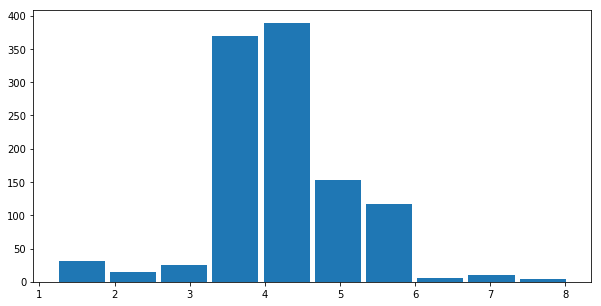

Previsão de Risco:


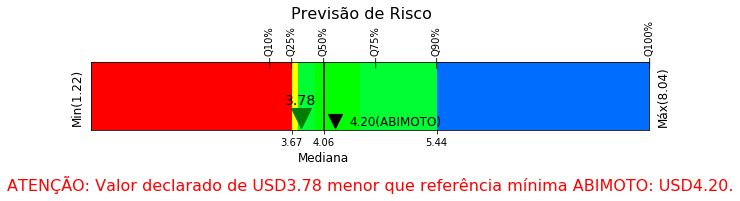

In [21]:
riscoValor(dfimp.iloc[0])

RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 881728 - SEMI-KIT DE TRANSMISSAO COMPOSTO DE COROA E PINHAO SEM CORRENTE UTILIZADO NAS MOTOS TITAN125-1999 - DENTES: 43/14 - MARCA: ALLEN
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 1.74
Tabela de Referência ABIMOTO
Valor:      USD 4.30


Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'


Histograma por Decil:


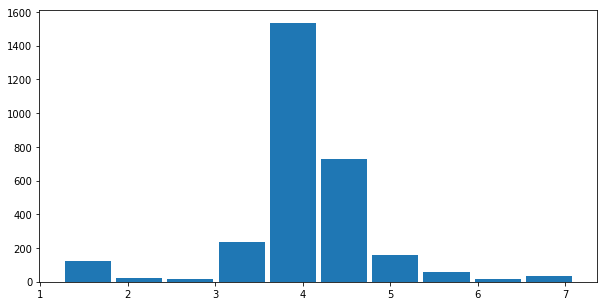


Previsão de Risco:


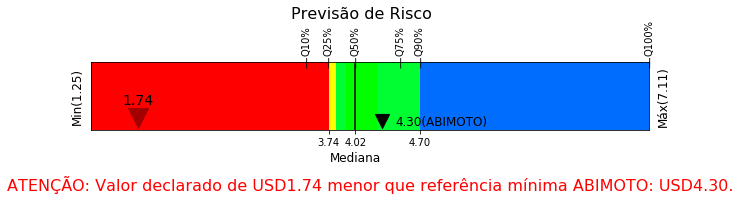




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10540017 IN KIT TRANSMISSAO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: NXR150BROS09 49D/17D/428UOX128L MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 7.83

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


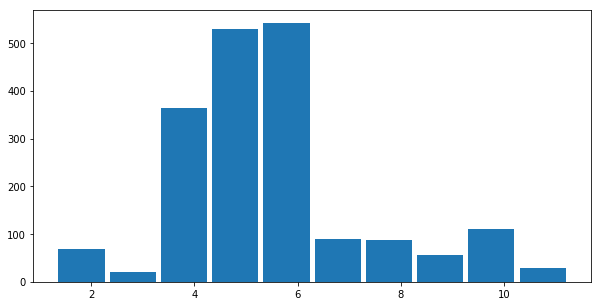


Previsão de Risco:


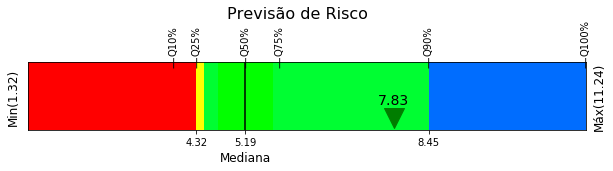




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 007271# KIT TRANSMISSAO STANDARD TEMP. COMPL. P/ MOTO HONDA XLR 125 97/02 (50T+14T-428H+126L) - COMPOSTO POR CORRENTE, COROA E PINHAO, MODELO: STD XLR 125
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA XLR
Valor DI:  USD 4.08

Estatísticas:
qtd de registros:    218.000000
média simples:         5.186359
desvio padrão:         1.398228
valor mínimo:          1.895160
percentil 25%:         4.349370
percentil 50%:         4.750000
percentil 75%:         6.437524
valor máximo:          8.399000

Percentis:
  '10=1.90', '20=4.08', '25=4.35', '30=4.34', '40=4.43', '50=4.64'
  '60=4.75', '70=4.78', '75=6.44', '80=6.39', '90=6.55', '100=7.35'


Histograma por Decil:


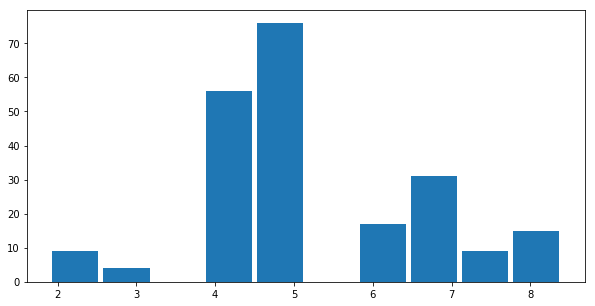


Previsão de Risco:


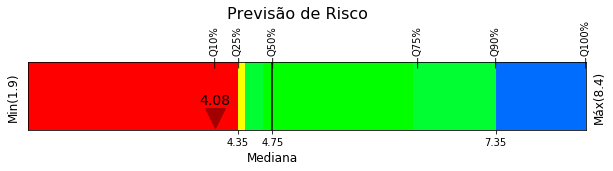




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS YS 250 FAZER (06-17), COMPOSTO DE CORRENTE 428 X M122 + COROA 41601 45Z + PINHAO 26593 15Z (CERTIFICADO NR. BR31512030) - ITEM: 71879
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FAZER YS250 250
Valor DI:  USD 6.25
Tabela de Referência ABIMOTO
Valor:      USD 4.50


Estatísticas:
qtd de registros:    466.000000
média simples:         5.571051
desvio padrão:         1.735652
valor mínimo:          1.467516
percentil 25%:         4.210000
percentil 50%:         5.372500
percentil 75%:         6.760000
valor máximo:         11.358313

Percentis:
  '10=1.47', '20=3.82', '25=4.21', '30=4.10', '40=4.35', '50=4.61'
  '60=5.37', '70=6.31', '75=6.76', '80=6.73', '90=6.89', '100=7.76'


Histograma por Decil:


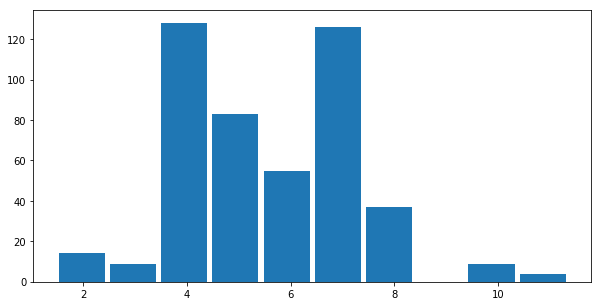


Previsão de Risco:


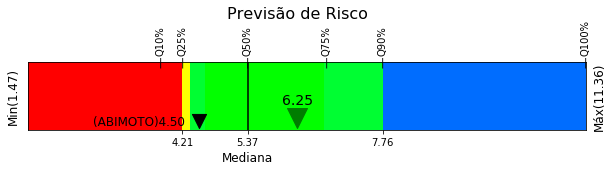




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 1104966 - DAROM/ KIT DE TRANSMISSÃO 428 - 1104966 - BIZ 100 / CONTENDO: 1 COROA 1800504 1 PINHÃO 1800483 1 CORRENTE 1104999/ GTIN: 7909201030140. CERTIFICADO NO: 16K-0005.01-01
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.32
Tabela de Referência ABIMOTO
Valor:      USD 3.90


Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'


Histograma por Decil:


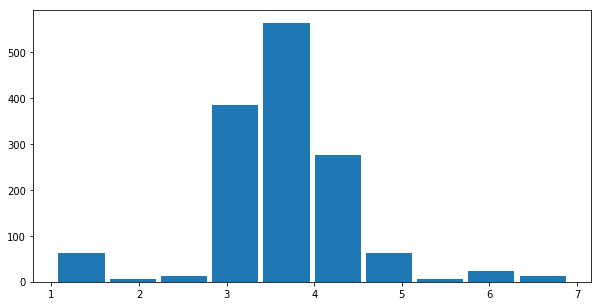


Previsão de Risco:


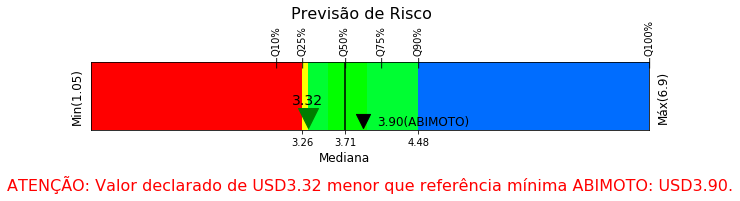




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 125 CARGO (00-04)/ CG 125 FAN (05-08)/ CG 125 TITAN (00-04), COMPOSTO DE CORRENTE 428 X SM117 + COROA S40038 44Z + PINHAO 25002 14Z (CERTIFICADO NR. BR31512030) - ITEM: 71790
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.09
Tabela de Referência ABIMOTO
Valor:      USD 4.30


Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'


Histograma por Decil:


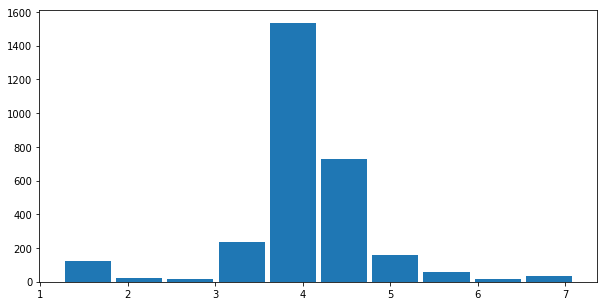


Previsão de Risco:


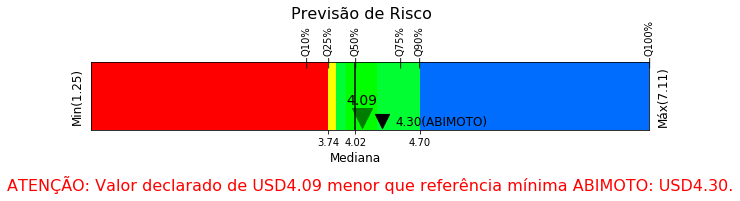




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 22318 - 91163 - KIT DE TRANSMISSAO PARA MOTOCICLETA MODELO: CG 125 FAN (14-16) / CG 125 CARGO (14-16) / CG 125I FAN (16-18) / CG 125I CARGO (16-18) - CONTENDO: COROA 43Z - PINHAO 14Z - CORRENTE 428H X 118L TITANIUM (1045) - REGISTRO 002044/2019
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG FAN
Valor DI:  USD 4.70

Estatísticas:
qtd de registros:    1074.000000
média simples:          4.045164
desvio padrão:          0.640457
valor mínimo:           1.413541
percentil 25%:          3.810000
percentil 50%:          4.010770
percentil 75%:          4.500000
valor máximo:           6.580000

Percentis:
  '10=1.41', '20=3.57', '25=3.81', '30=3.73', '40=3.89', '50=3.97'
  '60=4.01', '70=4.11', '75=4.50', '80=4.29', '90=4.53', '100=4.70'


Histograma por Decil:


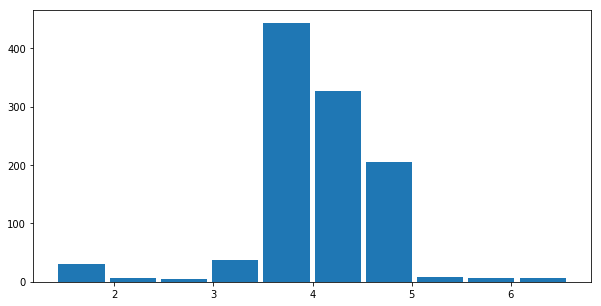


Previsão de Risco:


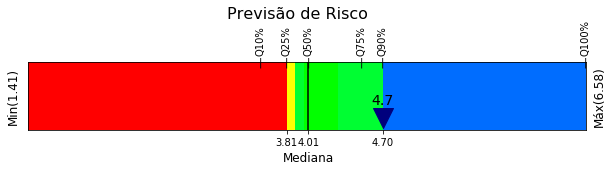




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO, MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS NXR 150 BROS ESD (03- 05), COMPOSTO DE CORRENTE 428 X M121 + COROA 40109 50Z + PINHAO 25115 17Z (CERTIFICADO NR. BR31512030) - ITEM: 71848
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 5.80

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


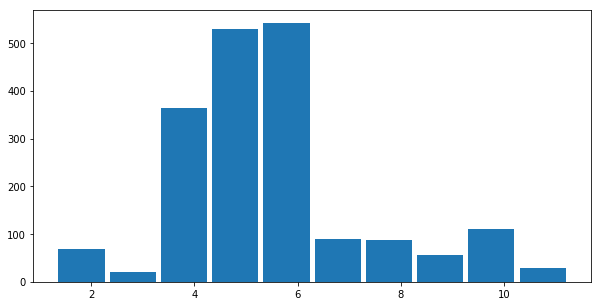


Previsão de Risco:


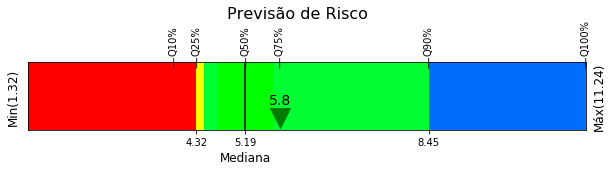




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: K519B: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE, COROA E PINHAO UTILIZADO EM MOTOCICLETAS/MOTONETAS. COD: K519B. APLICACAO: NXR 150 BROS ESD STANDARD. CORRENTE: 428H +130L. COROA: 50T. PINHAO: 17T. MARCA: GULFAIR. REGISTRO INMETRO 009581/2019 - 009582
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 3.86

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


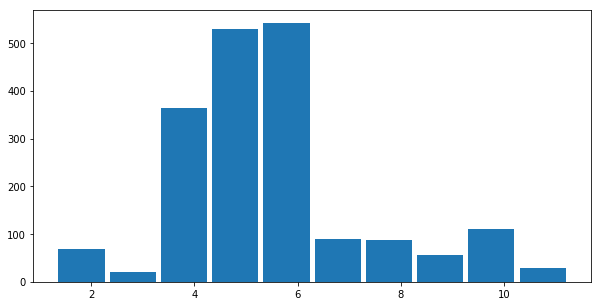


Previsão de Risco:


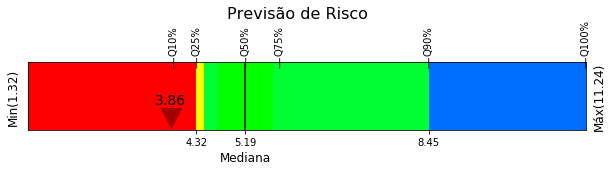




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT TRANSMISSÃO COMPATÍVEL COM MOTO HONDA NXR BROSS 150. -2006 A 2015. COMPOSTO DE CORRENTE, COROA E PINHÃO. KIT COROA 50T + PINHÃO 17T + CORRENTE 428H X 130L DE MOTOCICLETAS (INCLUINDO OS CICLOMOTORES) CONFECCIONADO EM AÇO 1045. MODELO: BROS 150. 20
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 4.34

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


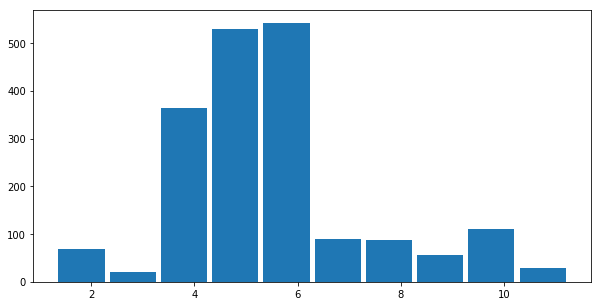


Previsão de Risco:


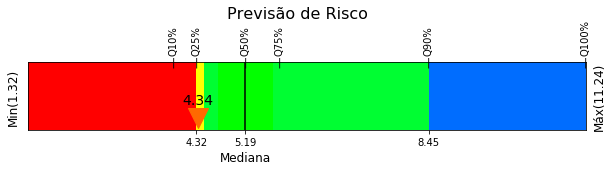




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS CG 125 CARGO (00-04)/ CG 125 FAN (05-08)/ CG 125 TITAN (00-04), COMPOSTO DE CORRENTE 428 X SM117 + COROA S40038 44Z + PINHAO 25002 14Z (CERTIFICADO NR. BR31512030) - ITEM: 71790
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.09
Tabela de Referência ABIMOTO
Valor:      USD 4.30


Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'


Histograma por Decil:


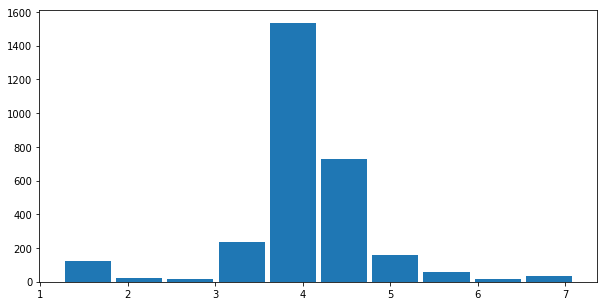


Previsão de Risco:


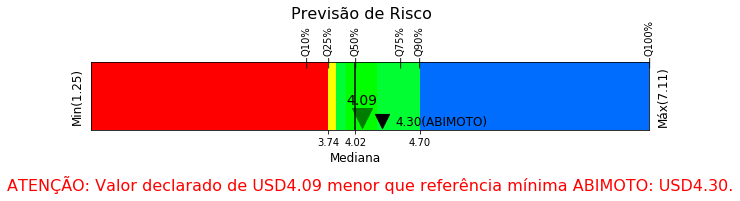




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT HARDT CG150 TITAN/FAN HO 43*16 - KIT DE TRANSMISSAO COM RETENTOR COMPOSTO DE COROA/PINHAO E CORRENTE PARA MODELO: CG150 TITAN/FAN, COROA/PINHAO: 43*16, CORRENTE DA MOTOCICLETA 428HO E ELOS 118. REF. 55537C.
Origem:    CHINA, REPUBLICA POP
Retentor:  com retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.58
Tabela de Referência ABIMOTO
Valor:      USD 7.50


Estatísticas:
qtd de registros:    159.000000
média simples:         6.821068
desvio padrão:         2.224207
valor mínimo:          3.518600
percentil 25%:         4.181560
percentil 50%:         7.840100
percentil 75%:         8.701244
valor máximo:         10.338940

Percentis:
  '10=3.52', '20=3.66', '25=4.18', '30=3.78', '40=5.08', '50=6.38'
  '60=7.84', '70=8.20', '75=8.70', '80=8.50', '90=8.98', '100=9.02'


Histograma por Decil:


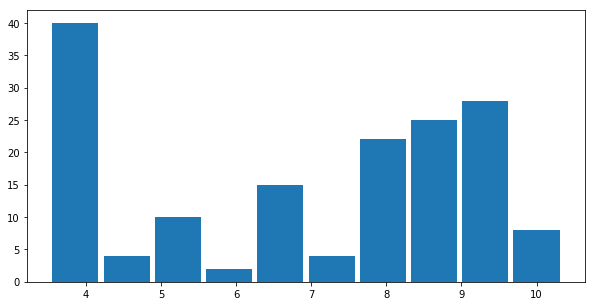


Previsão de Risco:


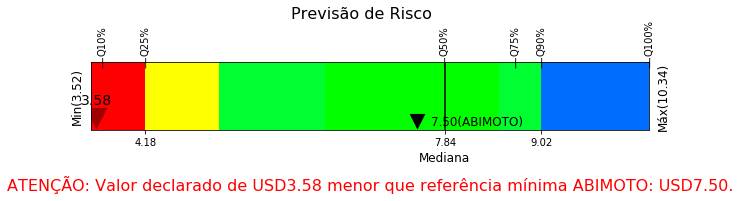




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 25135 - 91089 - KIT DE TRANSMISSAO PARA MOTOCICLETA MODELO NXR 150 BROS (06-15), CONTENDO: COROA 49Z - PINHAO 17Z - C/CORRENTE 428HO X 128L - TOP (1045) - REGISTRO 002044/2019
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 10.83

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


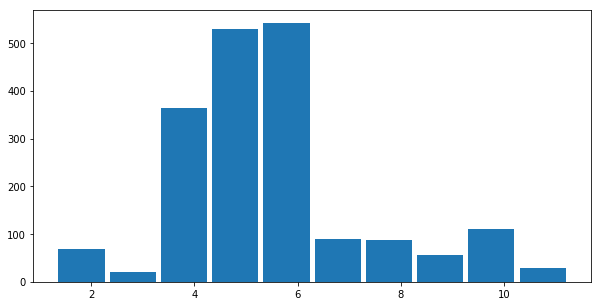


Previsão de Risco:


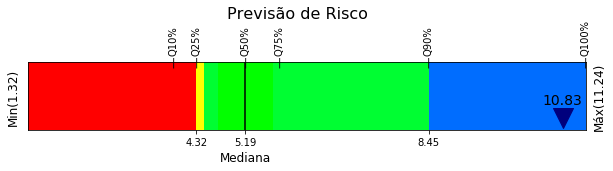




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 71899 KIT POP 100 (07-15) 35Z X 14Z WITH CHAIN 428H X 106L - TITANIUM (1045) KIT TRANSMISSAO PARA MOTOCICLETA, COMPOSTO POR COROA, PINHAO E CORRENTE.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA POP 100
Valor DI:  USD 4.15

Estatísticas:
qtd de registros:    738.000000
média simples:         3.602477
desvio padrão:         0.732581
valor mínimo:          1.083128
percentil 25%:         3.224200
percentil 50%:         3.622425
percentil 75%:         4.120000
valor máximo:          5.000000

Percentis:
  '10=1.08', '20=2.95', '25=3.22', '30=3.10', '40=3.29', '50=3.46'
  '60=3.62', '70=3.81', '75=4.12', '80=4.09', '90=4.19', '100=4.45'


Histograma por Decil:


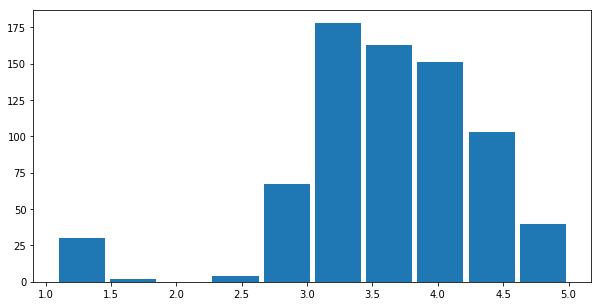


Previsão de Risco:


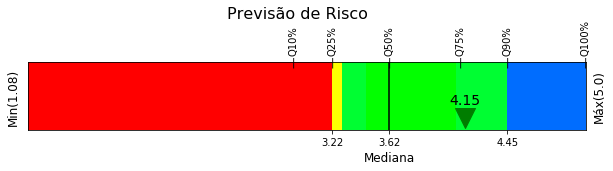




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE MEDIDAS: 520H X 106L, COROA C/PROT MEDIDAS: 37T, E PINHAO MEDIDAS: 13T. COMPATIVEL COM MOTOCICLETA(S) MODELO(S): CBX 250 TWISTER. CODIGO: 509.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 5.63
Tabela de Referência ABIMOTO
Valor:      USD 6.25


Estatísticas:
qtd de registros:    565.000000
média simples:         7.699036
desvio padrão:         2.985285
valor mínimo:          1.574895
percentil 25%:         5.810000
percentil 50%:         7.360000
percentil 75%:         8.530000
valor máximo:         16.968750

Percentis:
  '10=1.57', '20=4.93', '25=5.81', '30=5.55', '40=5.96', '50=6.84'
  '60=7.36', '70=7.84', '75=8.53', '80=8.44', '90=8.77', '100=12.70'


Histograma por Decil:


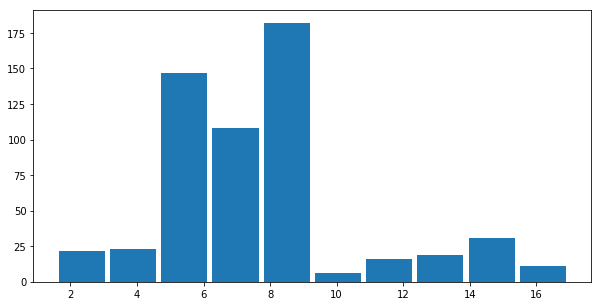


Previsão de Risco:


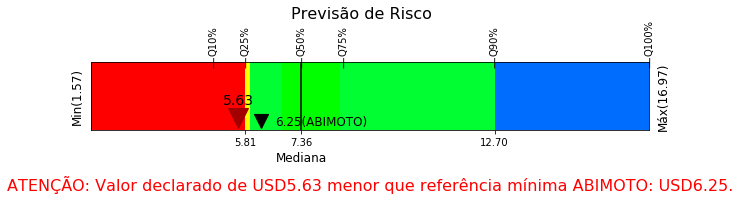




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 5008.809.215 "KIT TRANSMISSÃO UNIFORT (CORRENTE, COROA E PINHÃO) QTY DE LIGACOES DA CORRENTE 118 MATERIAL DA COROA E DO PINHAO, AÇO CORRENTE 428X118 SEM RETENTOR COROA 43 DENTES PINHÃO 15 DENTES MARCA: Unifort CÓDIGO: 5008.809.215 APLICAÇÃO: YBR 125"
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 4.35
Tabela de Referência ABIMOTO
Valor:      USD 4.20


Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'


Histograma por Decil:


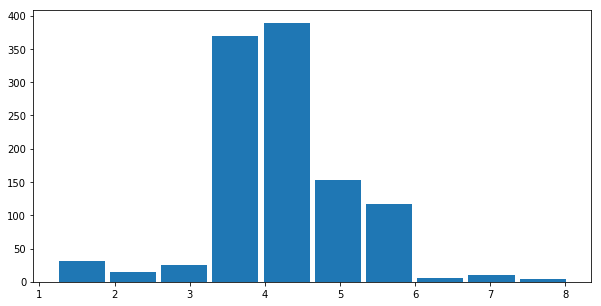


Previsão de Risco:


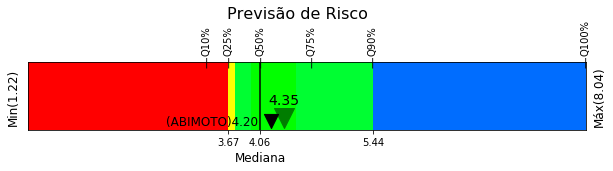




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS NXR 150 BROS (06-15), COMPOSTO DE CORRENTE 428 X M121 + COROA 40176 49Z + PINHAO 25115 17Z (CERTIFICADO NR. BR31512030) - ITEM: 71884
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 5.67

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


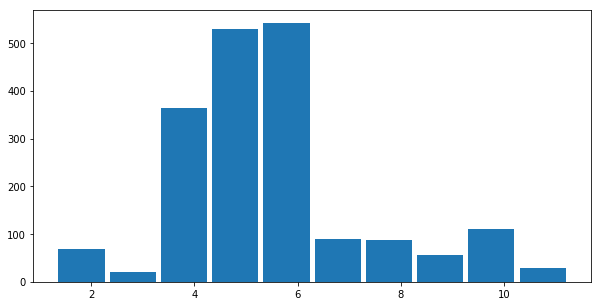


Previsão de Risco:


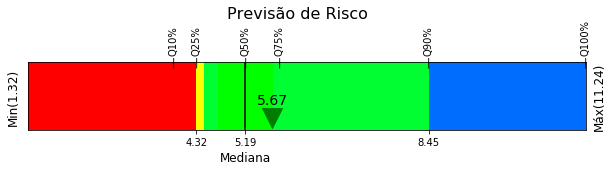




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE MEDIDAS: 520H X 106L, COROA C/PROT MEDIDAS: 37T, E PINHAO MEDIDAS: 13T. COMPATIVEL COM MOTOCICLETA(S) MODELO(S): CBX 250 TWISTER. CODIGO: 509.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA TWISTER CBX 250
Valor DI:  USD 5.63
Tabela de Referência ABIMOTO
Valor:      USD 6.25


Estatísticas:
qtd de registros:    565.000000
média simples:         7.699036
desvio padrão:         2.985285
valor mínimo:          1.574895
percentil 25%:         5.810000
percentil 50%:         7.360000
percentil 75%:         8.530000
valor máximo:         16.968750

Percentis:
  '10=1.57', '20=4.93', '25=5.81', '30=5.55', '40=5.96', '50=6.84'
  '60=7.36', '70=7.84', '75=8.53', '80=8.44', '90=8.77', '100=12.70'


Histograma por Decil:


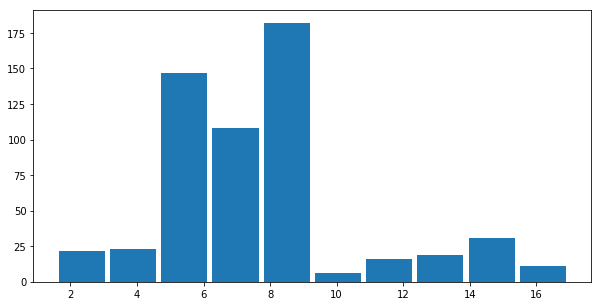


Previsão de Risco:


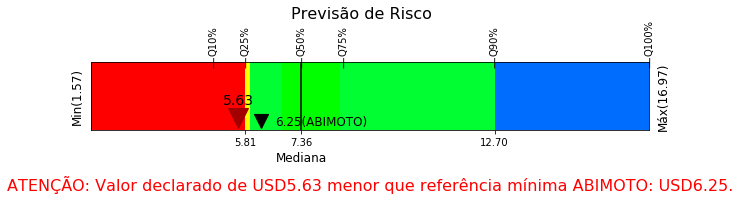




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 24800 - 358563 - KIT DE TRANSMISSÃO PARA MOTOCICLETA MODELO FACTOR 150 (16-18) - CONTENDO: COROA 39Z - PINHAO 14Z - C/CORRENTE 428H X 124L - MARCA: EVOL
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 5.84
Tabela de Referência ABIMOTO
Valor:      USD 4.20


Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'


Histograma por Decil:


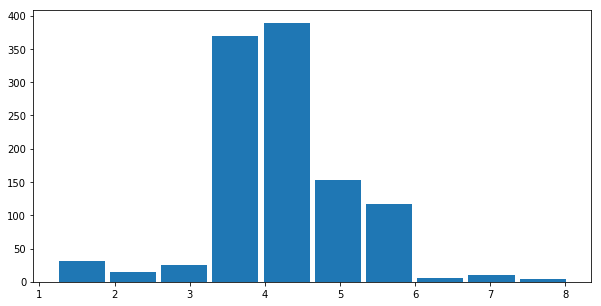


Previsão de Risco:


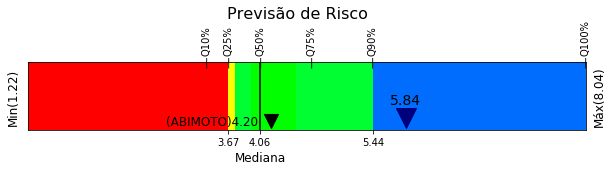




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 21989 - 71815 - KIT DE TRANSMISSAO PARA MOTOCICLETA MODELO: YBR 125 (03-08) / YBR 125 FACTOR (03-16) - CONTENDO: COROA 45Z - PINHAO 14Z - C/CORRENTE 428H X 118L - TITANIUM (1045) - REGISTRO 002044/2019
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 4.95
Tabela de Referência ABIMOTO
Valor:      USD 4.20


Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'


Histograma por Decil:


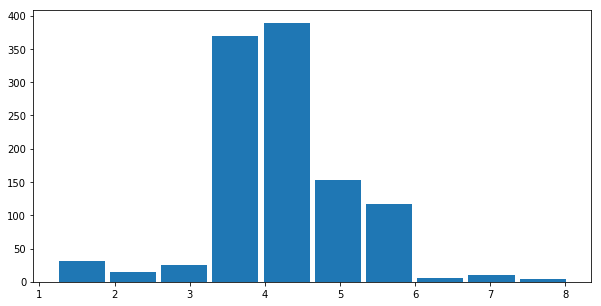


Previsão de Risco:


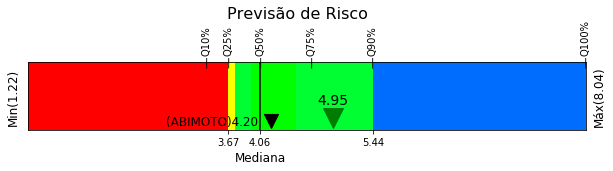




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 070577 - KIT TRANSMISSÃO COMPOSTO DE CORRENTE, COROA E PINHÃO, PARA MOTOCICLETA, SENDO: KIT RELAÇÃO MAXX XR 200 43/13 520HX108 - MARCA MAXX PREMIUM
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA XR
Valor DI:  USD 5.97

Estatísticas:
qtd de registros:    64.000000
média simples:        7.206114
desvio padrão:        1.846087
valor mínimo:         2.300000
percentil 25%:        5.933874
percentil 50%:        7.148491
percentil 75%:        8.380000
valor máximo:        12.130000

Percentis:
  '10=2.30', '20=5.26', '25=5.93', '30=5.53', '40=6.31', '50=6.38'
  '60=7.15', '70=8.10', '75=8.38', '80=8.27', '90=8.38', '100=9.03'


Histograma por Decil:


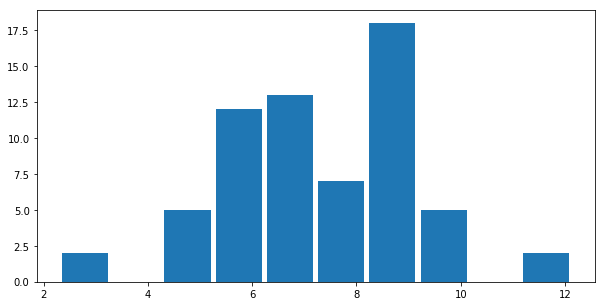


Previsão de Risco:


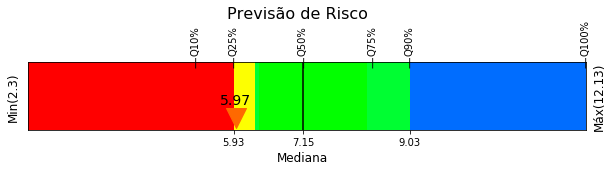




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: - CEVER CODE 0024307 - KIT DE TRANSMISSÃO, EM AÇO 1045 TEMPERADO, PARA USO EM MOTOCICLETA, COMPOSTO POR CORRENTE COROA E PINHÃO, APLICAÇÃO BROS 150 .
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 3.95

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


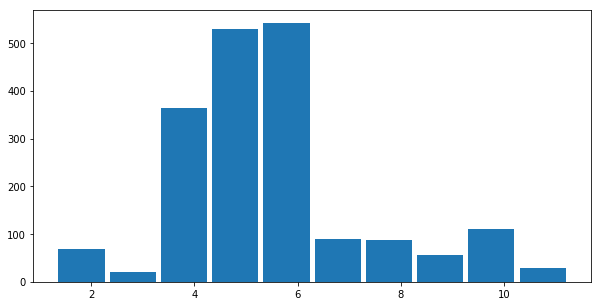


Previsão de Risco:


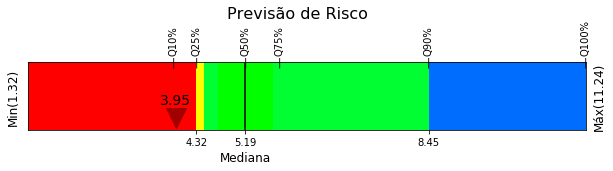




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KTD0110 - KIT DE TRANSMISSÃO PARA MOTOCICLETAS, COMPOSTO DE CORRENTE, COROA E PINHÃO, SEM RETENTOR, MODELO: 428HX104L,34T/14T POP 110i , MARCA DUAS ALMAS
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA POP 100
Valor DI:  USD 3.38

Estatísticas:
qtd de registros:    738.000000
média simples:         3.602477
desvio padrão:         0.732581
valor mínimo:          1.083128
percentil 25%:         3.224200
percentil 50%:         3.622425
percentil 75%:         4.120000
valor máximo:          5.000000

Percentis:
  '10=1.08', '20=2.95', '25=3.22', '30=3.10', '40=3.29', '50=3.46'
  '60=3.62', '70=3.81', '75=4.12', '80=4.09', '90=4.19', '100=4.45'


Histograma por Decil:


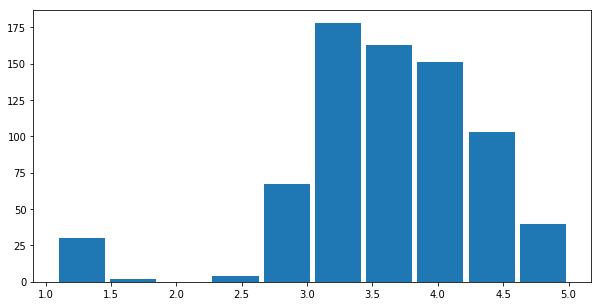


Previsão de Risco:


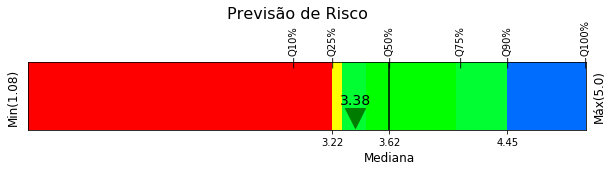




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ENGRENAGENS PARA TRANSMISSÃO DE MOTOCICLETAS E CICLOMOTORES, SENDO, KIT DE TRANSMISSÃO TOP( 1045 ) PARA NXR 150 BROS, (71848) COMPOSTO DE CORRENTE 428HO X 130L , COROA 50Z, PINHÃO 17Z COM ANEL - ITEM 91092.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 9.80

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


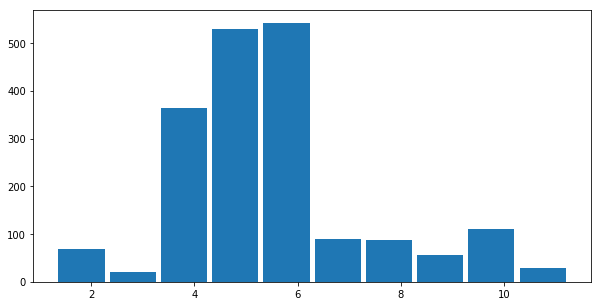


Previsão de Risco:


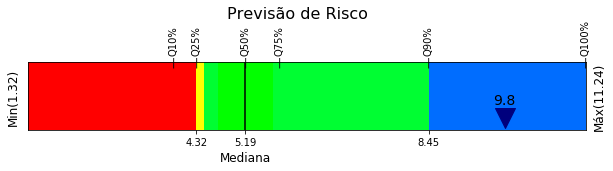




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO P/ MOTOCICLETA MOD.: CG 160 FAN (16-18) / CG 160 START(16-18) / CG 160 TITAN (16-18) / CG 160 CARGO (16-17) / CG 150 TITAN (04-15); CONTENDO COROA 44Z; PINHAO 15Z E CORRENTE DE TRANSMISSAO 428H X 118L - TITANIUM (1045), 91177 91177
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.60
Tabela de Referência ABIMOTO
Valor:      USD 4.30


Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'


Histograma por Decil:


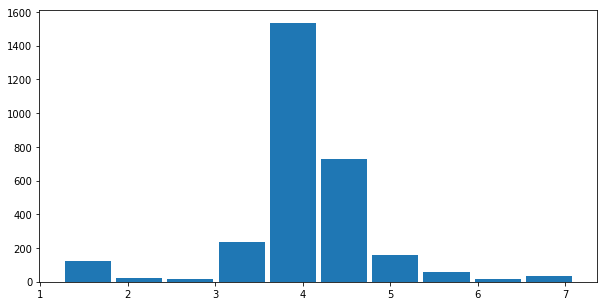


Previsão de Risco:


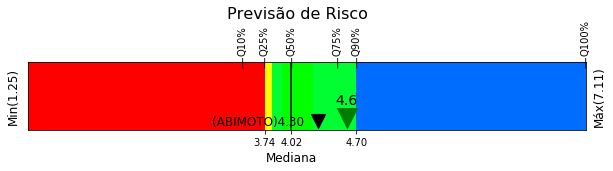




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TOP (1045) PARA MOTOCICLETAS NXR 160 BROS (15-18)/ XRE 190 (16-17), COMPOSTO DE CORRENTE 428 X M389 + COROA 40285 48Z + PINHAO 25122 16Z (CERTIFICADO NR. BR31512030) - ITEM: 91190
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 9.80

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


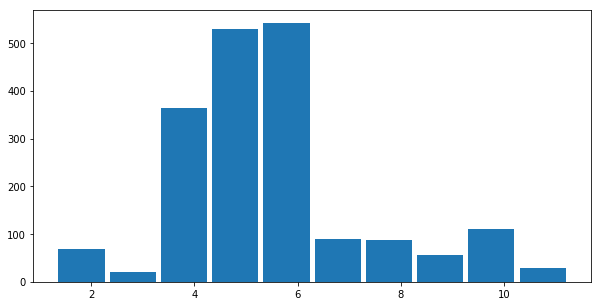


Previsão de Risco:


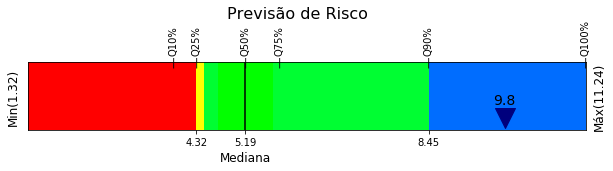




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE MEDIDAS: 428H X 106L, COROA C/PROT MEDIDAS: 34T, E PINHAO MEDIDAS: 14T. COMPATIVEL COM MOTOCICLETA(S) MODELO(S): BIZ 125. CODIGO: 9127.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.23
Tabela de Referência ABIMOTO
Valor:      USD 3.90


Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'


Histograma por Decil:


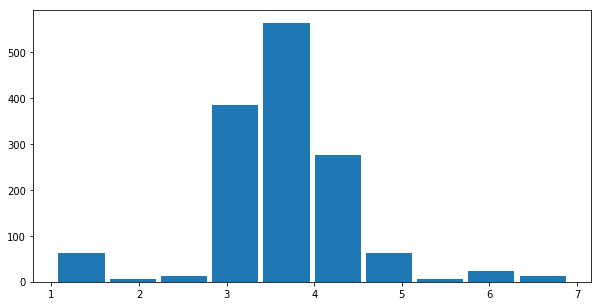


Previsão de Risco:


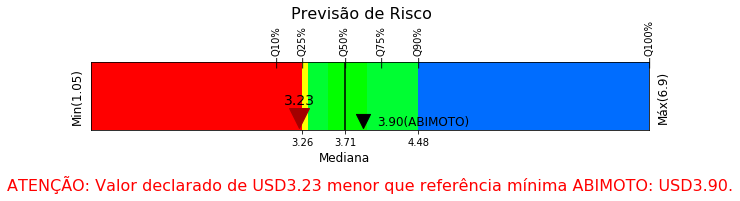




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: - KIT TRANSMISSAO TITANIUM PARA MOTOCICLETAS MODELO CG 125 CARGO (89-99)/CG 125 TODAY (89-94)/CG 125 TITAN (95/99) 43Z X 14Z - WITH CHAIN 428H X 116L, COMPOSTO POR CORRENTE, COROA E PINHÃO. CORRENTE FABRICADA EM AÇO, PERFIL: 428 REFORÇADA, 116 ELOS;
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.50
Tabela de Referência ABIMOTO
Valor:      USD 4.30


Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'


Histograma por Decil:


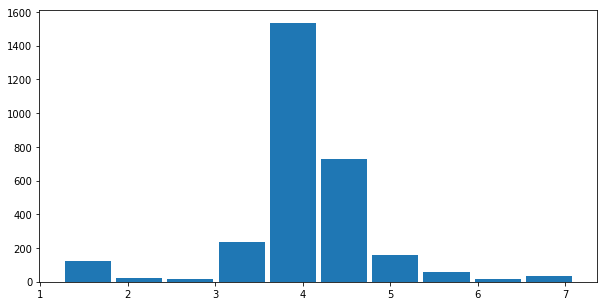


Previsão de Risco:


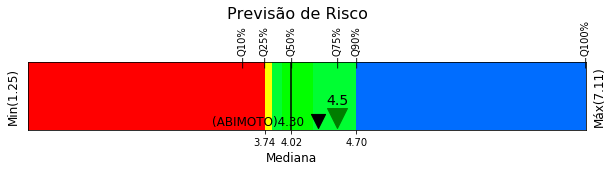




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 980714 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO PARA MOTOCICLETA C100 BIZ 98/06 - 1045 428H X 108L X 35T X 15T, MARCA VELTH.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.11
Tabela de Referência ABIMOTO
Valor:      USD 3.90


Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'


Histograma por Decil:


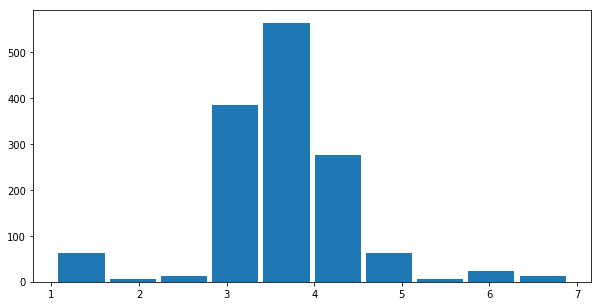


Previsão de Risco:


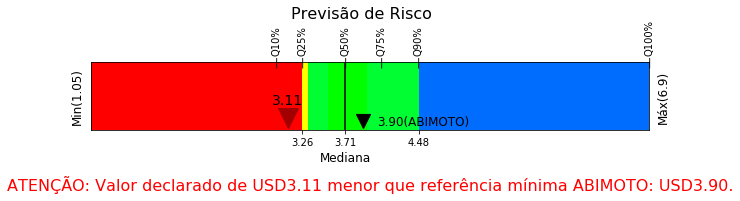




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: K507B: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE, COROA E PINHAO UTILIZADO EM MOTOCICLETAS/MOTONETAS. COD: K507B. APLICACAO: CG150 TITAN/KS/ES/MIX/FAN STANDARD. CORRENTE: 428H+118L. COROA: 43T. PINHAO: 16T. MARCA: GULFAIR.REGISTRO INMETRO 009581/2019 -
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 3.45
Tabela de Referência ABIMOTO
Valor:      USD 4.30


Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'


Histograma por Decil:


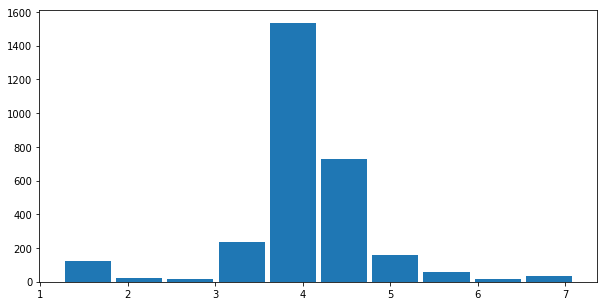


Previsão de Risco:


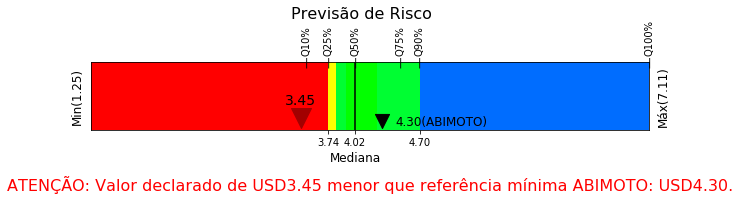




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ITEM 1000247WR - KIT TRANSMISSÃO COMPOSTO DE COROA, CORRENTE E PINHÃO, PARA MOTOCICLETA MARCA WR COMPATÍVEL WEB 100/DREAM 36T-14T/428H 108L EM CX COM 10 UNIDADES
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA DREAM
Valor DI:  USD 39.02

Estatísticas:
qtd de registros:    82.000000
média simples:       13.166888
desvio padrão:       13.582114
valor mínimo:         2.867400
percentil 25%:        4.190000
percentil 50%:        4.937750
percentil 75%:       28.674000
valor máximo:        39.023256

Percentis:
  '10=2.87', '20=3.10', '25=4.19', '30=3.43', '40=4.19', '50=4.32'
  '60=4.94', '70=5.07', '75=28.67', '80=27.56', '90=28.67', '100=35.62'


Histograma por Decil:


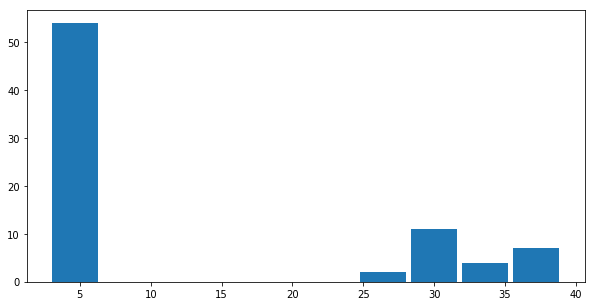


Previsão de Risco:


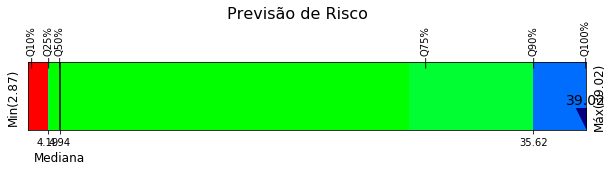




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS NXR 150 BROS ESD (03-05), COMPOSTO DE CORRENTE 428 X M121 + COROA 40109 50Z + PINHAO 25115 17Z - ITEM: 71848
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 5.55

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


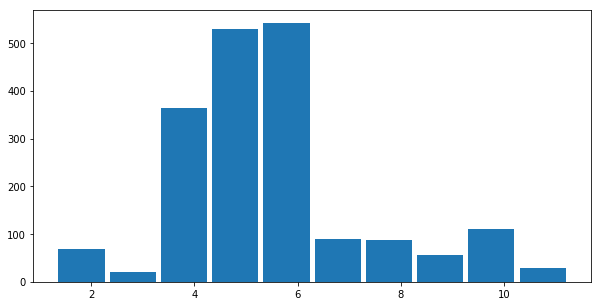


Previsão de Risco:


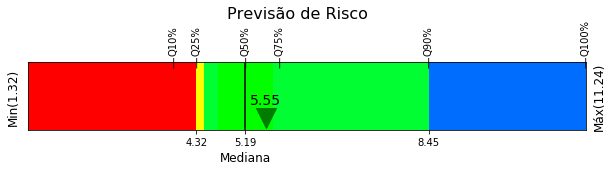




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO PARA MOTOCICLETAS MODELO: CBX 200 / XR 200 ; CONTENDO COROA 43Z; PINHAO 13Z (94-03) E CORRENTE DE TRANSMISSAO CHAIN 520H X 108L - TITANIUM (1045), 71738 71738
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA XR
Valor DI:  USD 8.46

Estatísticas:
qtd de registros:    64.000000
média simples:        7.206114
desvio padrão:        1.846087
valor mínimo:         2.300000
percentil 25%:        5.933874
percentil 50%:        7.148491
percentil 75%:        8.380000
valor máximo:        12.130000

Percentis:
  '10=2.30', '20=5.26', '25=5.93', '30=5.53', '40=6.31', '50=6.38'
  '60=7.15', '70=8.10', '75=8.38', '80=8.27', '90=8.38', '100=9.03'


Histograma por Decil:


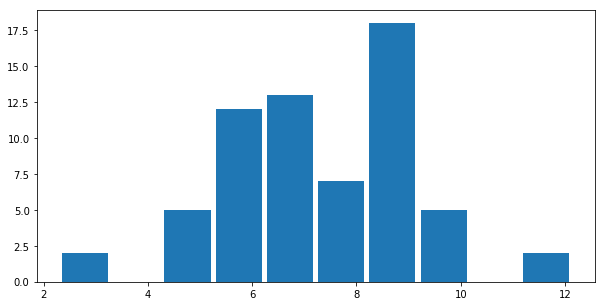


Previsão de Risco:


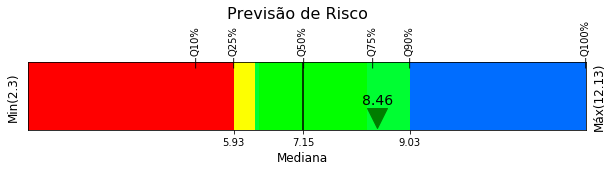




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: tem 01;Partes e peças para Motocicletas,Destaque 009-kit de Transmissão composto de corrente,coroa e pinhão;Tipo/modelo:KIT CG 150 TITAN(04-15)/CG 150 FAN(09-15)/CG 150 START(14-15)/CG 150 CARGO(14-15)43Z X 16Z WITH CHAIN 428H X 118L-TITANIUM(1045);N
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.92
Tabela de Referência ABIMOTO
Valor:      USD 4.30


Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'


Histograma por Decil:


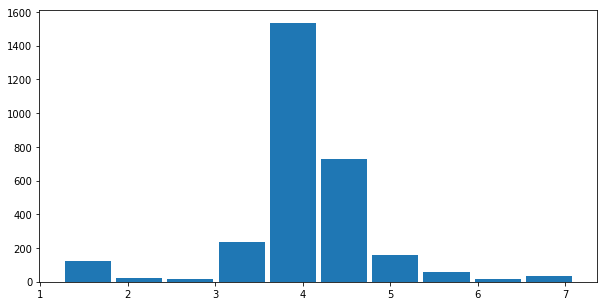


Previsão de Risco:


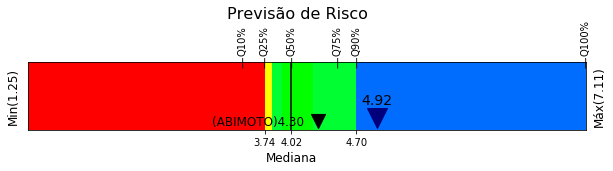




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO, COMPOSTO DE CORRENTE, COROA E PINHAO PARA MOTO MODELO BIZ 125
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 6.17
Tabela de Referência ABIMOTO
Valor:      USD 3.90


Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'


Histograma por Decil:


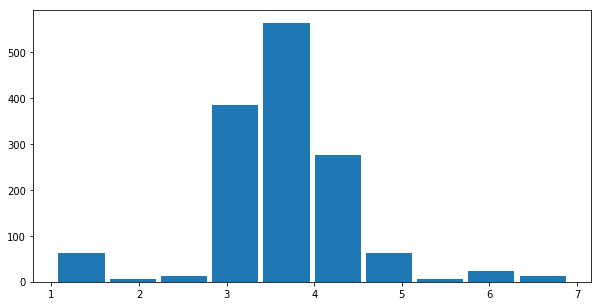


Previsão de Risco:


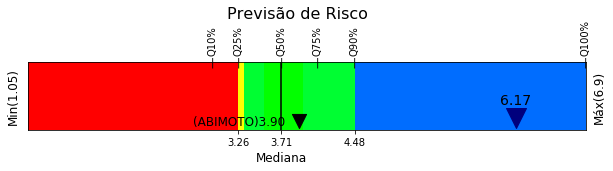




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO COMPOSTO DE CORRENTE MEDIDAS: 428H X 116L, COROA S/ PROT MEDIDAS: 43T, E PINHAO MEDIDAS: 14T. COMPATIVEL COM MOTOCICLETA(S) MODELO(S): SUZ YES/KATANA 125 TODAS. MARCA: JC MAXI. CODIGO: 25196.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUZUKI KATANA
Valor DI:  USD 3.76

Estatísticas:
qtd de registros:    81.000000
média simples:        3.581391
desvio padrão:        0.586368
valor mínimo:         1.241000
percentil 25%:        3.350000
percentil 50%:        3.645600
percentil 75%:        3.979000
valor máximo:         4.500000

Percentis:
  '10=1.24', '20=3.27', '25=3.35', '30=3.35', '40=3.42', '50=3.58'
  '60=3.65', '70=3.76', '75=3.98', '80=3.92', '90=3.98', '100=4.00'


Histograma por Decil:


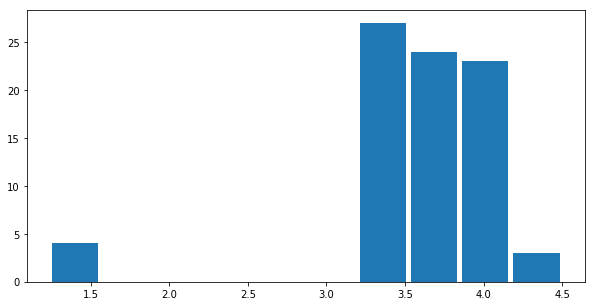


Previsão de Risco:


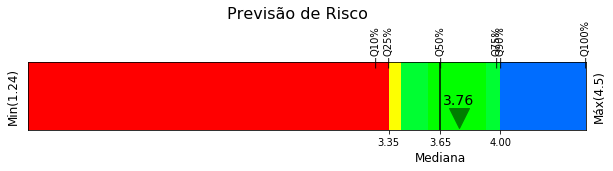




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO PARA MOTOCICLETA EM ACO 1045, COMPOSTO POR CORRENTE, COROA E PINHAO, APLICACAO NXR 160 BROS / XRE 190 (48T/16T + 428H x128L)
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 4.46

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


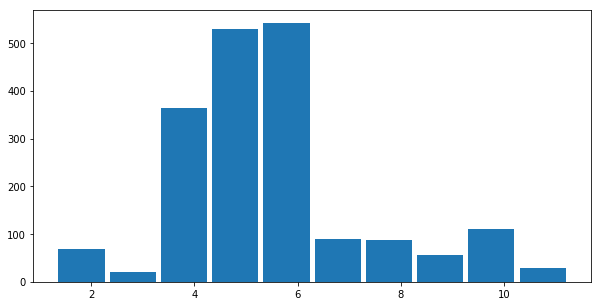


Previsão de Risco:


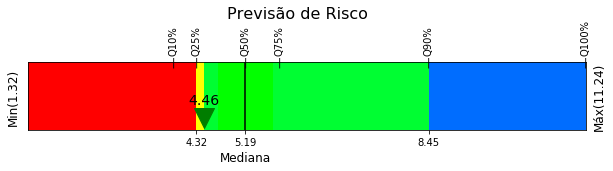




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: TM10215 - KIT DE TRANSMISSÃO COMPOSTO DE COROA, CORRENTE E PINHÃO PARA MOTOCICLETA - UTILIZADAS NAS MOTOCICLETAS - XTZ 125 - (48 - 14T + 428H X 122L) - SUA FUNÇÃO É TRANSMITIR O MOVIMENTO DA CAIXA DE CÂMBIO ATÉ A RODA TRASEIRA, TAMBÉM É RESPONSAVEL P
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA XTZ 125
Valor DI:  USD 3.85

Estatísticas:
qtd de registros:    314.000000
média simples:         4.871234
desvio padrão:         1.396000
valor mínimo:          1.559612
percentil 25%:         3.930000
percentil 50%:         4.409778
percentil 75%:         5.950000
valor máximo:          9.578000

Percentis:
  '10=1.56', '20=3.75', '25=3.93', '30=3.86', '40=3.97', '50=4.30'
  '60=4.41', '70=5.14', '75=5.95', '80=5.87', '90=5.99', '100=6.29'


Histograma por Decil:


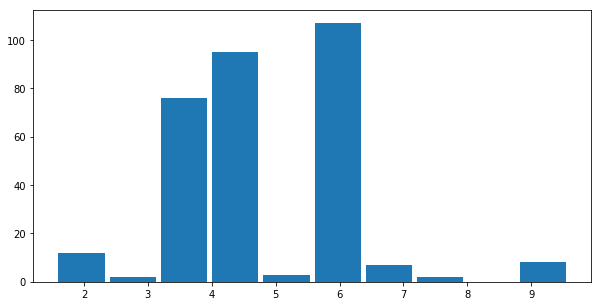


Previsão de Risco:


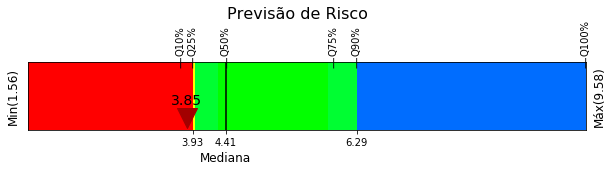




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS BIZ 125 (05-17), COMPOSTO DE CORRENTE 428 X SM133 + COROA S40173 34Z + PINHAO 25132 14Z - ITEM: 71877
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.97
Tabela de Referência ABIMOTO
Valor:      USD 3.90


Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'


Histograma por Decil:


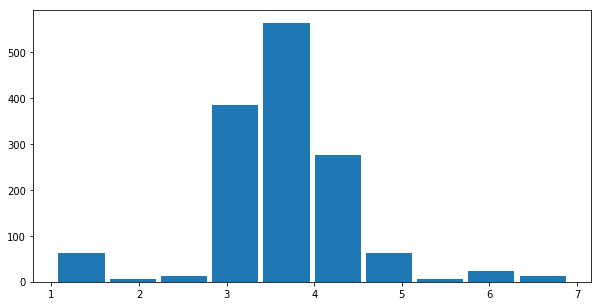


Previsão de Risco:


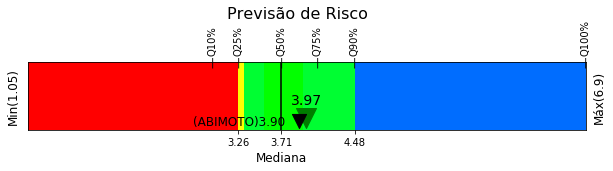




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 880416 - KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO, UTILIZADO NAS MOTOS FACTOR125 09 1045 - MARCA KMC GOLD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA FACTOR YBR 125 YBR125
Valor DI:  USD 5.67
Tabela de Referência ABIMOTO
Valor:      USD 4.20


Estatísticas:
qtd de registros:    1123.000000
média simples:          4.152855
desvio padrão:          0.908013
valor mínimo:           1.216719
percentil 25%:          3.666567
percentil 50%:          4.060000
percentil 75%:          4.686000
valor máximo:           8.036000

Percentis:
  '10=1.22', '20=3.40', '25=3.67', '30=3.58', '40=3.75', '50=3.95'
  '60=4.06', '70=4.13', '75=4.69', '80=4.50', '90=4.83', '100=5.44'


Histograma por Decil:


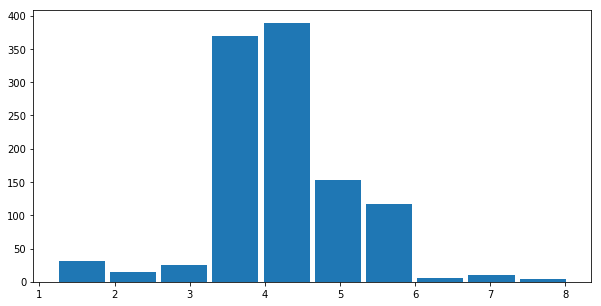


Previsão de Risco:


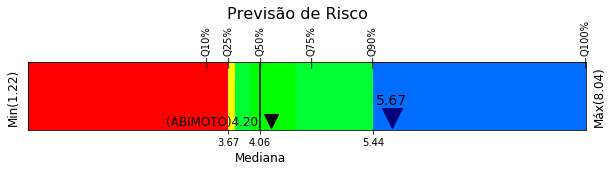




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10530021 IN KIT TRANSMISSÃO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) WEB-100 14D/36D 428HX108L MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: SUNDOWN WEB
Valor DI:  USD 3.57

Estatísticas:
qtd de registros:    219.000000
média simples:         3.805657
desvio padrão:         1.038534
valor mínimo:          1.107000
percentil 25%:         3.281631
percentil 50%:         3.573000
percentil 75%:         4.580000
valor máximo:          5.638000

Percentis:
  '10=1.11', '20=2.89', '25=3.28', '30=3.20', '40=3.35', '50=3.46'
  '60=3.57', '70=3.91', '75=4.58', '80=4.53', '90=4.80', '100=5.29'


Histograma por Decil:


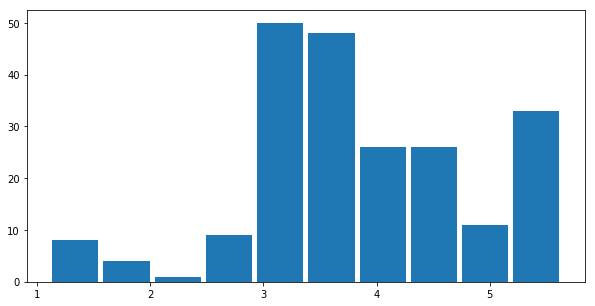


Previsão de Risco:


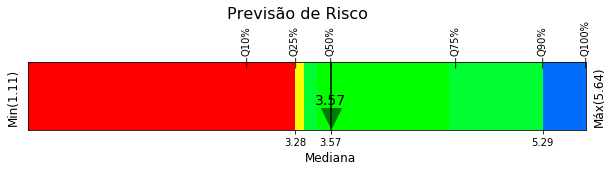




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO PARA MOTOCICLETA, CONTENDO CORRENTE, COROA E PINHAO, COMPATIVEL COM XTZ 250 LANDER A/08 46D/15D 428*130L - REF.:LV118D06
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: YAMAHA LANDER XTZ 250
Valor DI:  USD 4.81
Tabela de Referência ABIMOTO
Valor:      USD 4.40


Estatísticas:
qtd de registros:    428.000000
média simples:         7.539407
desvio padrão:         3.493309
valor mínimo:          1.533400
percentil 25%:         4.440000
percentil 50%:         6.997000
percentil 75%:         9.933113
valor máximo:         17.473750

Percentis:
  '10=1.53', '20=3.94', '25=4.44', '30=4.35', '40=5.04', '50=6.48'
  '60=7.00', '70=8.25', '75=9.93', '80=8.75', '90=10.29', '100=11.34'


Histograma por Decil:


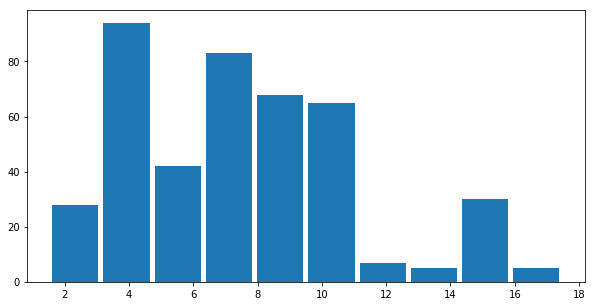


Previsão de Risco:


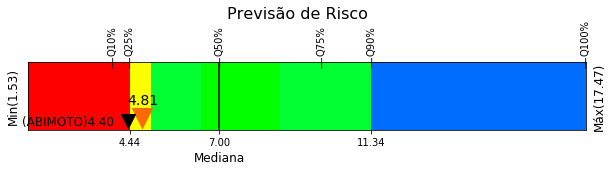




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KT0254 - KIT DE TRANSMISSÃO PARA MOTOCICLETAS, COMPOSTO DE CORRENTE, COROA E PINHÃO, COM RETENTOR, MODELO: 520HOx106L,43T/14T NINJA 250/300 , MARCA KING
Origem:    CHINA, REPUBLICA POP
Retentor:  com retentor
Aplicação: KAWASAKI NINJA 300
Valor DI:  USD 4.98

Estatísticas:
qtd de registros:    28.000000
média simples:        9.903007
desvio padrão:        3.097366
valor mínimo:         4.855200
percentil 25%:        8.782000
percentil 50%:        8.812000
percentil 75%:       13.301977
valor máximo:        14.231872

Percentis:
  '10=4.86', '20=5.39', '25=8.78', '30=7.67', '40=8.78', '50=8.78'
  '60=8.81', '70=10.59', '75=13.30', '80=13.08', '90=13.41', '100=13.75'


Histograma por Decil:


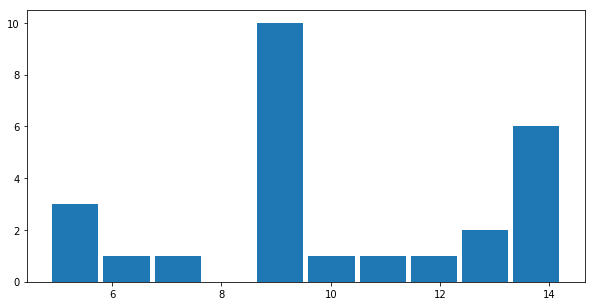


Previsão de Risco:


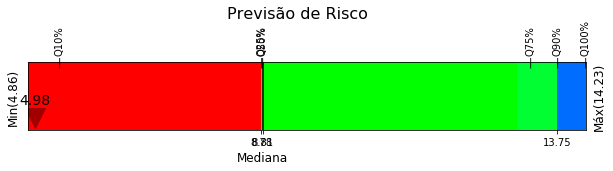




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: item 01;Partes e peças para Motocicletas,Destaque 002-Kit de Transmissão composto de corrente,coroa e pinhão;p/modelo:KIT C 100 BIZ(13-15)34Z X 14Z WITH CHAIN 428H X 108L-TITANIUM(1045);Nas Qdes:200unidades;Ref.:91131.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 4.27
Tabela de Referência ABIMOTO
Valor:      USD 3.90


Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'


Histograma por Decil:


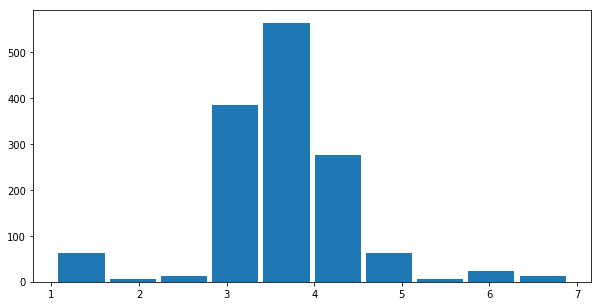


Previsão de Risco:


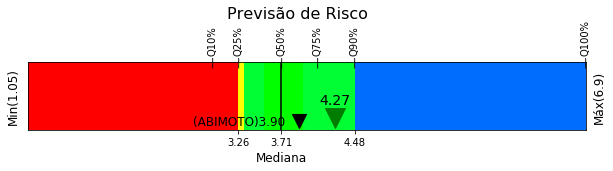




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 10540002 IN KIT TRANSMISSAO P/MOTOCICLETAS(COROA, CORRENTE, PINHAO) MODELO: NXR150BROS 50D/17D/428UOX130L MARCA: SCUD
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA NXR 150 BROS BROZ
Valor DI:  USD 7.96

Estatísticas:
qtd de registros:    1896.000000
média simples:          5.471736
desvio padrão:          1.854546
valor mínimo:           1.324344
percentil 25%:          4.320000
percentil 50%:          5.190000
percentil 75%:          5.803800
valor máximo:          11.235385

Percentis:
  '10=1.32', '20=3.92', '25=4.32', '30=4.20', '40=4.45', '50=4.71'
  '60=5.19', '70=5.55', '75=5.80', '80=5.68', '90=6.08', '100=8.45'


Histograma por Decil:


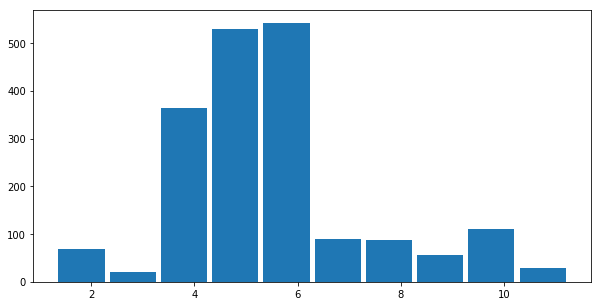


Previsão de Risco:


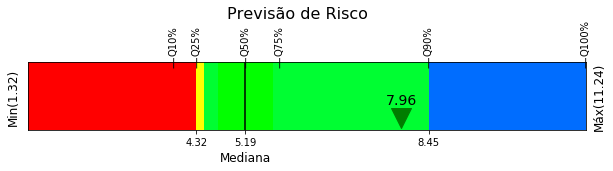




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO, MODELO: KIT BIZ 125 34X14 428HX106L.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.58
Tabela de Referência ABIMOTO
Valor:      USD 3.90


Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'


Histograma por Decil:


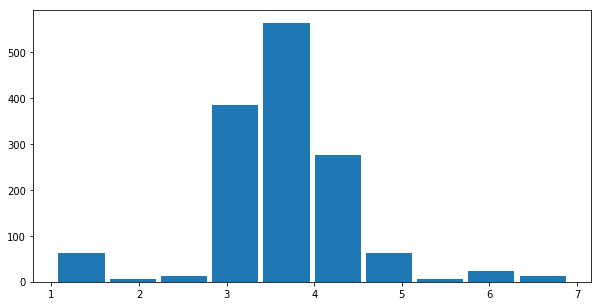


Previsão de Risco:


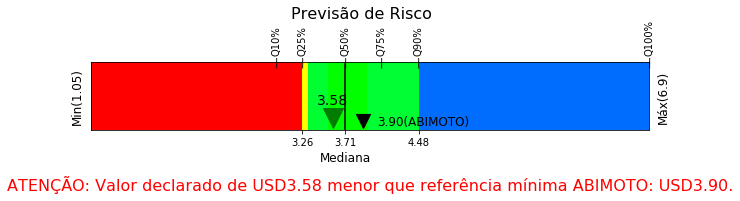




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: 24729 - 71788 - KIT DE TRANSMISSAO PARA MOTOCICLETA MODELO CG 125 CARGO (89-99) / CG 125 TODAY (89-94) / CG 125 TITAN (95-99) CONTENDO: COROA 43Z - PINHAO 14Z - C/CORRENTE 428H X 116L TITANIUM (1045) - REGISTRO 002044/2019
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 4.70
Tabela de Referência ABIMOTO
Valor:      USD 4.30


Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'


Histograma por Decil:


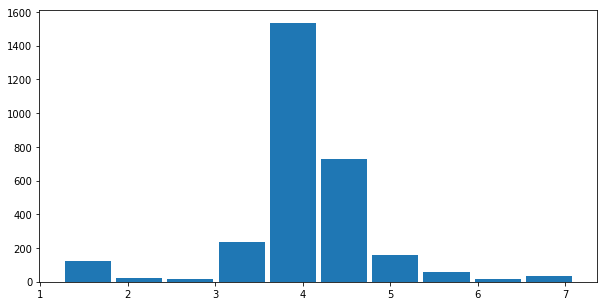


Previsão de Risco:


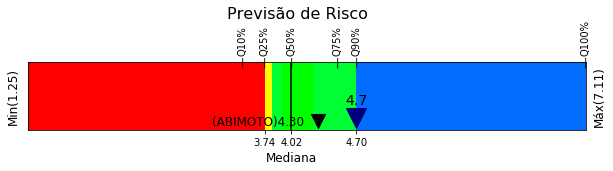




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: ENGRENAGENS PARA TRANSMISSÃO DE MOTOCICLETAS E CICLOMOTORES, SENDO, KIT DE TRANSMISSÃO TOP (1045) PARA CG 125 TITAN ES/KS, COMPOSTO DE CORRENTE 428H X 116L, COROA 44Z, PINHÃO 14Z (71790), COM O'RING ITEM 91083.
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA CG TIT TITAN 125 150 160
Valor DI:  USD 7.91
Tabela de Referência ABIMOTO
Valor:      USD 4.30


Estatísticas:
qtd de registros:    2927.000000
média simples:          4.033758
desvio padrão:          0.791698
valor mínimo:           1.250000
percentil 25%:          3.740000
percentil 50%:          4.020619
percentil 75%:          4.500000
valor máximo:           7.111000

Percentis:
  '10=1.25', '20=3.51', '25=3.74', '30=3.67', '40=3.82', '50=3.92'
  '60=4.02', '70=4.10', '75=4.50', '80=4.25', '90=4.55', '100=4.70'


Histograma por Decil:


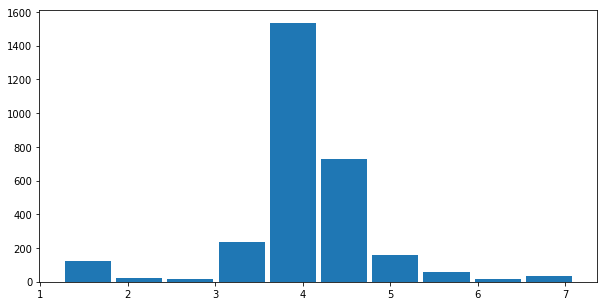


Previsão de Risco:


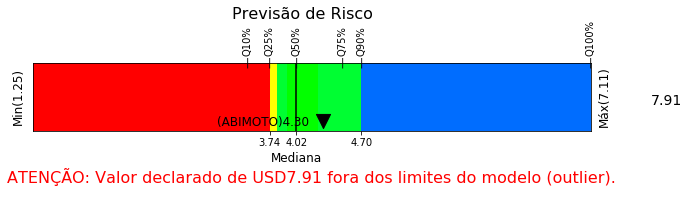




RELATÓRIO DE RISCO

Dados da Declaração de Importação
Descrição: KIT DE TRANSMISSAO , MARCA RIFFEL, TITANIUM (1045) PARA MOTOCICLETAS C 100 BIZ (98-05)/ C 100 BIZ+ (02-05), COMPOSTO DE CORRENTE 428 X SM116 + COROA S40029 35Z + PINHAO 25018 15Z (CERTIFICADO NR. BR31512030) - ITEM: 71782
Origem:    CHINA, REPUBLICA POP
Retentor:  sem retentor
Aplicação: HONDA BIZ 100 C100 125 C125
Valor DI:  USD 3.83
Tabela de Referência ABIMOTO
Valor:      USD 3.90


Estatísticas:
qtd de registros:    1409.000000
média simples:          3.648339
desvio padrão:          0.817363
valor mínimo:           1.051025
percentil 25%:          3.255806
percentil 50%:          3.708000
percentil 75%:          4.090000
valor máximo:           6.900000

Percentis:
  '10=1.05', '20=2.99', '25=3.26', '30=3.19', '40=3.32', '50=3.53'
  '60=3.71', '70=3.76', '75=4.09', '80=3.94', '90=4.13', '100=4.48'


Histograma por Decil:


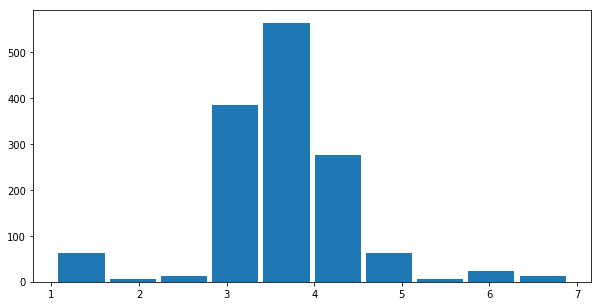


Previsão de Risco:


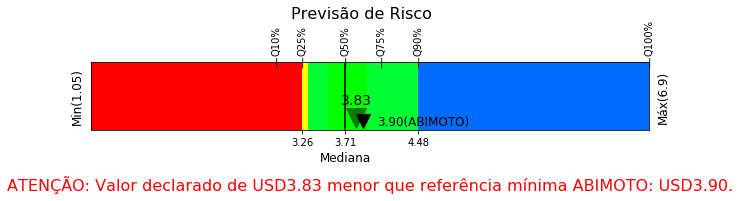

In [17]:
riscoValor(dfimp.iloc[1:])